In [ ]:
from collections import defaultdict, Counter
import json
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cityblock
from scipy.stats import pearsonr, shapiro
from scipy.linalg import expm

from utils import (
    prepare_exp_aa_subst, amino_acid_codes,
    get_equilibrium_freqs, get_equilibrium_probabilities,
)

## Prepare data

### Load ref

In [39]:
amino_acid_codes_rev = {v: k for k, v in amino_acid_codes.items()}

In [60]:
with open('./data/ref_aa_freqs_mean.json') as f:
    aa_freqs_total_dct_ref = json.load(f)
aa_freqs_total_dct_ref = {amino_acid_codes_rev[k]: v for k, v in aa_freqs_total_dct_ref.items()}
aa_freqs_total_dct_ref

{'R': 350,
 'V': 782,
 'C': 296,
 'G': 577,
 'S': 661,
 'A': 659,
 'L': 930,
 'T': 718,
 'P': 394,
 'D': 511,
 'Y': 448,
 'F': 501,
 'I': 513,
 'N': 532,
 'K': 562,
 'Q': 365,
 'E': 442,
 'H': 189,
 'M': 207,
 'W': 111}

### Load genotypes from 2025

In [42]:
paths = glob.glob('./data/genotypes2025/gisaid_*.tsv')
paths

['./data/genotypes2025/gisaid_hcov-19_2025_05_29_10(7).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(6).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(5).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(4).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(3).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(2).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(1).tsv']

In [43]:
genotypes = pd.concat([pd.read_csv(paths[i], sep='\t', index_col=1) for i in range(len(paths))])
print(genotypes.shape)
genotypes.head(2)

(59916, 15)


,Virus name,Collection date,Location,Host,Passage,Specimen,Additional host information,Sampling strategy,Sequencing technology,Assembly method,Comment,Comment type,Lineage,Clade,AA Substitutions
Accession ID,,,,,,,,,,,,,,,
EPI_ISL_19674224,hCoV-19/Australia/QLD0x015057/2025,2025-01-01,Oceania / Australia / Queensland,Human,Original,NaN,NaN,NaN,Nanopore,NaN,Gap of 2 nucleotide(s) found at refpos 11084 (...,warn,MC.1 (consensus call),GRA,"(NSP5_P132H,Spike_H69del,NSP3_T1465I,NSP3_G489..."
EPI_ISL_19674372,hCoV-19/Australia/SA2318258/2025,2025-01-02,Oceania / Australia / South Australia,Human,Original,NaN,NaN,NaN,Nanopore MinION,NaN,Gap of 45 nucleotides when compared to the ref...,warn,KP.3.1.1 (consensus call),GRA,"(NSP5_P132H,Spike_H69del,NSP3_T1465I,NSP3_G489..."


In [44]:
genotypes.Host.value_counts()

Host
Human    59916
Name: count, dtype: int64

In [45]:
genotypes.Passage.value_counts()

Passage
Original              59862
Culture passage 0        46
Vero E6, P2               3
Vero E6/TMPRSS2 P0        2
Vero E6/TMPRSS2 P1        2
Vero E6 P2                1
Name: count, dtype: int64

In [46]:
genotypes['Lineage'].value_counts().head(10)

Lineage
XEC (consensus call)          13887
LP.8.1.1 (consensus call)      5829
KP.3.1.1 (consensus call)      2868
LP.8.1 (consensus call)        2600
MC.1 (consensus call)          1380
XEC                            1366
JN.1.11 (consensus call)       1175
JN.1.16.1 (consensus call)     1160
XEC.4 (consensus call)         1111
XEC.2 (consensus call)         1060
Name: count, dtype: int64

In [47]:
genotypes['Clade'].value_counts()

Clade
GRA    59414
GR       490
G          5
O          2
GK         1
Name: count, dtype: int64

In [48]:
genotypes['Collection date'].agg(['min', 'max'])

min    2025-01-01
max    2025-05-22
Name: Collection date, dtype: object

In [49]:
genotypes = genotypes.query('Clade == "GRA" & Passage == "Original"')
genotypes.shape

(59361, 15)

In [50]:
genotypes.index.to_series().to_csv('./data/genotypes2025/AccessionIDs.tsv', 
                                   sep='\t', index=False, header=False)

In [51]:
# Mutability of proteins

genotypes['AA Substitutions'].apply(
    lambda x: pd.Series(Counter([y.split('_')[0] for y in x.strip('()').split(',')])))\
        .mean(0).sort_values(ascending=False)

Spike    65.118175
N         8.079766
NSP3      7.521875
NSP6      4.977307
M         4.959254
NSP4      3.103341
NSP2      1.541883
NS3       1.521179
NS6       1.431631
NS7a      1.346249
NSP1      1.317833
NS8       1.229696
NSP12     1.181781
NSP14     1.167849
NSP13     1.130279
NSP15     1.086080
NSP5      1.076391
NSP16     1.060511
NSP9      1.045010
NSP8      1.037418
NSP7      1.027287
NSP10     1.021456
NS7b      1.018954
E         1.007606
dtype: float64

In [52]:
def collect_difference(aa_sbs: str, use_genes=None):
    use_genes = set(use_genes) if use_genes is not None else None

    aa_content_delta = defaultdict(int)

    for x in aa_sbs.strip('()').split(','):
        gene,mut = x.split('_')
        m = bool(re.match(r'^[A-Z]\d+[A-Z]$', mut))
        if m:
            if use_genes is not None and gene not in use_genes:
                continue
            aa1, aa2 = mut[0], mut[-1]
            aa_content_delta[aa1] -= 1
            aa_content_delta[aa2] += 1

        elif not m and not mut.endswith('del') and not mut.startswith('ins') and not mut.endswith('stop'):
            print('WARNING:', gene, mut, x)
    
    return pd.Series(aa_content_delta)

In [55]:
aa_delta = genotypes['AA Substitutions'].apply(collect_difference).fillna(0.)
aa_delta

,P,H,T,I,G,S,E,K,N,Y,...,Q,L,F,V,D,W,M,J,B,Z
Accession ID,,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19674224,-4.0,4.0,-9.0,9.0,-2.0,-2.0,0.0,9.0,-5.0,2.0,...,-5.0,3.0,4.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19674372,-4.0,4.0,-8.0,8.0,-2.0,0.0,0.0,10.0,-5.0,2.0,...,-5.0,3.0,3.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19675602,-4.0,4.0,-8.0,8.0,-2.0,-1.0,0.0,9.0,-5.0,2.0,...,-5.0,3.0,3.0,-2.0,0.0,2.0,0.0,0.0,0.0,0.0
EPI_ISL_19674356,-3.0,4.0,-7.0,7.0,-2.0,1.0,0.0,10.0,-4.0,2.0,...,-5.0,3.0,2.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0
EPI_ISL_19674361,-5.0,3.0,-7.0,8.0,-2.0,0.0,1.0,7.0,-5.0,2.0,...,-5.0,5.0,3.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,-3.0,3.0,-6.0,7.0,-2.0,-1.0,0.0,8.0,-5.0,2.0,...,-5.0,3.0,3.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19885820,-5.0,3.0,-7.0,8.0,-2.0,0.0,0.0,8.0,-5.0,2.0,...,-5.0,5.0,3.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0
EPI_ISL_19885830,-6.0,3.0,-7.0,8.0,-2.0,2.0,0.0,8.0,-5.0,2.0,...,-5.0,4.0,3.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [56]:
# mean change
aa_delta.fillna(0).mean(0).sort_values(ascending=False)

K    9.069878
I    7.955661
H    3.654824
L    3.454120
F    2.753070
Y    2.089773
C    1.223750
W    0.941763
S    0.329594
B    0.002780
J    0.002072
Z    0.002038
M   -0.026212
D   -0.110898
E   -0.165092
R   -1.181887
V   -1.266000
G   -2.053385
P   -3.926703
N   -4.273782
Q   -4.848048
A   -5.928556
T   -7.698758
dtype: float64

### All proteins ???

In [61]:
aa_content_full = aa_delta.drop(['J', 'B', 'Z'], axis=1).fillna(0) + aa_freqs_total_dct_ref
aa_content_full

,P,H,T,I,G,S,E,K,N,Y,C,R,A,Q,L,F,V,D,W,M
Accession ID,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19674224,390.0,193.0,709.0,522.0,575.0,659.0,442.0,571.0,527.0,450.0,298.0,350.0,654.0,360.0,933.0,505.0,780.0,511.0,112.0,207.0
EPI_ISL_19674372,390.0,193.0,710.0,521.0,575.0,661.0,442.0,572.0,527.0,450.0,298.0,349.0,653.0,360.0,933.0,504.0,780.0,511.0,112.0,207.0
EPI_ISL_19675602,390.0,193.0,710.0,521.0,575.0,660.0,442.0,571.0,527.0,450.0,298.0,349.0,654.0,360.0,933.0,504.0,780.0,511.0,113.0,207.0
EPI_ISL_19674356,391.0,193.0,711.0,520.0,575.0,662.0,442.0,572.0,528.0,450.0,297.0,348.0,653.0,360.0,933.0,503.0,781.0,511.0,112.0,206.0
EPI_ISL_19674361,389.0,192.0,711.0,521.0,575.0,661.0,443.0,569.0,527.0,450.0,297.0,350.0,653.0,360.0,935.0,504.0,781.0,511.0,112.0,207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,391.0,192.0,712.0,520.0,575.0,660.0,442.0,570.0,527.0,450.0,297.0,350.0,653.0,360.0,933.0,504.0,781.0,512.0,112.0,207.0
EPI_ISL_19885820,389.0,192.0,711.0,521.0,575.0,661.0,442.0,570.0,527.0,450.0,297.0,350.0,652.0,360.0,935.0,504.0,783.0,511.0,112.0,206.0
EPI_ISL_19885830,388.0,192.0,711.0,521.0,575.0,663.0,442.0,570.0,527.0,450.0,297.0,350.0,653.0,360.0,934.0,504.0,781.0,511.0,112.0,207.0


In [62]:
aa_content_full.sum(1)

Accession ID
EPI_ISL_19674224    9748.0
EPI_ISL_19674372    9748.0
EPI_ISL_19675602    9748.0
EPI_ISL_19674356    9748.0
EPI_ISL_19674361    9748.0
                     ...  
EPI_ISL_19885825    9748.0
EPI_ISL_19885820    9748.0
EPI_ISL_19885830    9748.0
EPI_ISL_19885805    9748.0
EPI_ISL_19881199    9748.0
Length: 59361, dtype: float64

In [63]:
sum(aa_freqs_total_dct_ref.values())

9748

In [67]:
aa_eq_freqs_20A = pd.read_csv('./data/20A/aa_eq_freqs.csv', index_col=0)
aa_eq_freqs_20A['eq_freq'] = aa_eq_freqs_20A['eq_freq'] * sum(aa_freqs_total_dct_ref.values())
aa_eq_freqs_20A

,eq_freq
aa,
Phe,3067.081476
Leu,1928.398100
Ser,1162.751188
Ile,847.083654
Tyr,717.832972
Val,430.516521
Cys,343.934785
Thr,246.201337
His,196.744859


In [68]:
aa_content_full.rename(columns=amino_acid_codes).to_csv('./data/aa_content_2025.csv')

In [69]:
aa_content_full.mean(0).rename('gisaid_2025')\
    .rename(index=amino_acid_codes).to_csv('./data/mean_aa_content_2025.csv', header=False)

## Compare expected and observed freq changes

In [236]:
def get_random_rate_matrix(n=20):
    """
    Generates a valid random 20x20 Q-matrix (infinitesimal generator).
    - Off-diagonals >= 0
    - Row sums = 0
    """
    # Create random matrix with positive values
    M = np.random.rand(n, n)
    
    # Zero out the diagonal initially
    np.fill_diagonal(M, 0)
    
    # Calculate row sums (off-diagonal sums)
    row_sums = M.sum(axis=1)
    
    # Set diagonal to negative of row sums to satisfy Q-matrix property
    # Q_ii = -sum(Q_ij for j != i)
    np.fill_diagonal(M, -row_sums)
    
    return M


def simulate_euler_method(Q, initial_vector, total_time, delta_t=0.01):
    """
    Forward Euler integration.
    Solves d(pi)/dt = pi * Q
    """
    pi = initial_vector.copy()
    times = [0]
    data = [pi.copy()]
    
    current_time = 0
    num_steps = int(total_time / delta_t)
    
    for _ in range(num_steps):
        # Euler step: pi(t+dt) = pi(t) + pi(t) @ Q * dt
        delta_pi = (pi @ Q) * delta_t
        pi_new = pi + delta_pi
        
        # Enforce non-negativity (Euler can overshoot into negatives)
        pi_new[pi_new < 0] = 0
        
        # Renormalize (Standard practice in numerical integration of probabilities)
        pi_new = pi_new / pi_new.sum()
        
        pi = pi_new
        current_time += delta_t
        
        times.append(current_time)
        data.append(pi.copy())
        
    return np.array(times), np.array(data)


def simulate_exact_method(Q, initial_vector, total_time, steps=100):
    """
    The 'Gold Standard' approach: Matrix Exponentiation.
    Solves pi(t) = pi(0) * e^(Qt)
    """
    times = np.linspace(0, total_time, steps)
    data = []
    
    # We can compute P(t) = e^(Qt)
    # Since pi(t) = pi(0) @ P(t)
    
    for t in times:
        if t == 0:
            data.append(initial_vector)
            continue
            
        # Compute transition matrix P for time t exactly
        P_t = expm(Q * t)
        
        pi_t = initial_vector @ P_t
        data.append(pi_t)
        
    return times, np.array(data)

In [3]:
clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


In [27]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221693,0.000000,0.000000,0.009019,0.000000,0.000000,0.009019,0.006342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013760,0.285607,0.086291,0.000000,0.000000,0.368270
Arg,0.000000,0.214378,0.000000,0.000000,0.148752,0.034855,0.000000,0.020866,0.034855,0.057681,0.230725,0.034855,0.057681,0.000000,0.011116,0.071700,0.005558,0.076979,0.000000,0.000000
Asn,0.000000,0.000000,0.597633,0.115183,0.000000,0.000000,0.000000,0.000000,0.019758,0.038093,0.000000,0.056297,0.000000,0.000000,0.000000,0.115183,0.019758,0.000000,0.038093,0.000000
Asp,0.010047,0.000000,0.129666,0.303882,0.000000,0.000000,0.028626,0.058568,0.020676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429167,0.019369
Cys,0.000000,0.056210,0.000000,0.000000,0.314091,0.000000,0.000000,0.008976,0.000000,0.000000,0.000000,0.000000,0.000000,0.443585,0.000000,0.033705,0.000000,0.009413,0.134022,0.000000
Gln,0.000000,0.127776,0.000000,0.000000,0.000000,0.205332,0.020789,0.000000,0.522793,0.000000,0.042258,0.059133,0.000000,0.000000,0.021918,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017562,0.000000,0.000000,0.418880,0.000000,0.036142,0.164519,0.102379,0.000000,0.000000,0.000000,0.226660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033858
Gly,0.014930,0.061746,0.000000,0.046816,0.154950,0.000000,0.046816,0.240551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046816,0.000000,0.077475,0.000000,0.309901
His,0.000000,0.057959,0.026823,0.009430,0.000000,0.028328,0.000000,0.000000,0.300722,0.000000,0.019168,0.000000,0.000000,0.000000,0.009942,0.000000,0.000000,0.000000,0.547628,0.000000


In [28]:
# TODO replace by direct aa content parsing
# ref_aa_freqs_mean.json

aa_content_ref = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_content_ref[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [89]:
aa_content25total = pd.read_csv('./data/aa_content_2025.csv', index_col=0)
aa_content25total_freqs = (aa_content25total.T / aa_content25total.sum(axis=1)).T

df_change_total = aa_content25total_freqs\
    .melt(ignore_index=False, value_name='gisaid25', var_name='aa')

df_change_total['refseq'] = df_change_total['aa'].map(aa_content_ref) / sum(aa_content_ref.values())

df_change_total['obs_change'] = df_change_total['gisaid25'] - df_change_total['refseq']
df_change_total['PE_obs'] = df_change_total['obs_change'] / df_change_total['refseq']*100

df_change_total

,aa,gisaid25,refseq,obs_change,PE_obs
Accession ID,,,,,
EPI_ISL_19674224,Pro,0.040008,0.040435,-0.000427,-1.055846
EPI_ISL_19674372,Pro,0.040008,0.040435,-0.000427,-1.055846
EPI_ISL_19675602,Pro,0.040008,0.040435,-0.000427,-1.055846
EPI_ISL_19674356,Pro,0.040111,0.040435,-0.000324,-0.802143
EPI_ISL_19674361,Pro,0.039906,0.040435,-0.000530,-1.309549
...,...,...,...,...,...
EPI_ISL_19885825,Met,0.021235,0.021244,-0.000009,-0.041034
EPI_ISL_19885820,Met,0.021133,0.021244,-0.000111,-0.523928
EPI_ISL_19885830,Met,0.021235,0.021244,-0.000009,-0.041034


In [90]:
mean_obs_change = df_change_total['obs_change'].abs().groupby('Accession ID').sum().mean()
mean_obs_change

np.float64(0.006509319997128249)

In [260]:
Q = Maa.copy()
Q = Q - np.diag(np.sum(Q, axis=1))

T_max = 0.02

# Run Simulations
t_exact, sim_freqs = simulate_exact_method(Q, aa_init_freqs, T_max, steps=100)

for i, f in enumerate(sim_freqs):
    sim_change = cityblock(f, aa_init_freqs)
    if sim_change >= mean_obs_change:
        print(i, mean_obs_change, sim_change)
        break

closest_sim_freqs_dct = dict(zip(Maa.columns, sim_freqs[i]))
sim_freqs[i]

73 0.006509319997128249 0.0065193131709168975


array([0.06692699, 0.03582331, 0.05488574, 0.05234881, 0.03046939,
       0.03710224, 0.0449961 , 0.0586205 , 0.01962459, 0.05336582,
       0.09590127, 0.05726613, 0.02122449, 0.05218081, 0.04011618,
       0.06802189, 0.07323308, 0.01134031, 0.04634746, 0.08020488])

In [261]:
df_change_total['sim'] = df_change_total['aa'].map(closest_sim_freqs_dct)
df_change_total['exp_change'] = df_change_total['sim'] - df_change_total['refseq']
df_change_total['PE_exp'] = df_change_total['exp_change'] / df_change_total['refseq']*100
df_change_total.head()

,aa,gisaid25,refseq,obs_change,PE_obs,sim,exp_change,PE_exp
Accession ID,,,,,,,,
EPI_ISL_19674224,Pro,0.040008,0.040435,-0.000427,-1.055846,0.040116,-0.000319,-0.788811
EPI_ISL_19674372,Pro,0.040008,0.040435,-0.000427,-1.055846,0.040116,-0.000319,-0.788811
EPI_ISL_19675602,Pro,0.040008,0.040435,-0.000427,-1.055846,0.040116,-0.000319,-0.788811
EPI_ISL_19674356,Pro,0.040111,0.040435,-0.000324,-0.802143,0.040116,-0.000319,-0.788811
EPI_ISL_19674361,Pro,0.039906,0.040435,-0.000530,-1.309549,0.040116,-0.000319,-0.788811


In [262]:
# used for visualization
quantiles = df_change_total.groupby('aa')[['PE_exp', 'PE_obs']].quantile([0.25, 0.5, 0.75])
quantiles.index.names = ['aa', 'quantile']
quantiles = quantiles.reset_index()
quantiles.head()

,aa,quantile,PE_exp,PE_obs
0,Ala,0.25,-0.891095,-0.800601
1,Ala,0.50,-0.891095,-0.800601
2,Ala,0.75,-0.891095,-0.648687
3,Arg,0.25,-0.267897,-0.612228
4,Arg,0.50,-0.267897,-0.326631


In [263]:
losers = []
gainers = ['Ser', 'Leu', 'His', 'Ile', 'Cys', 'Tyr', 'Phe']

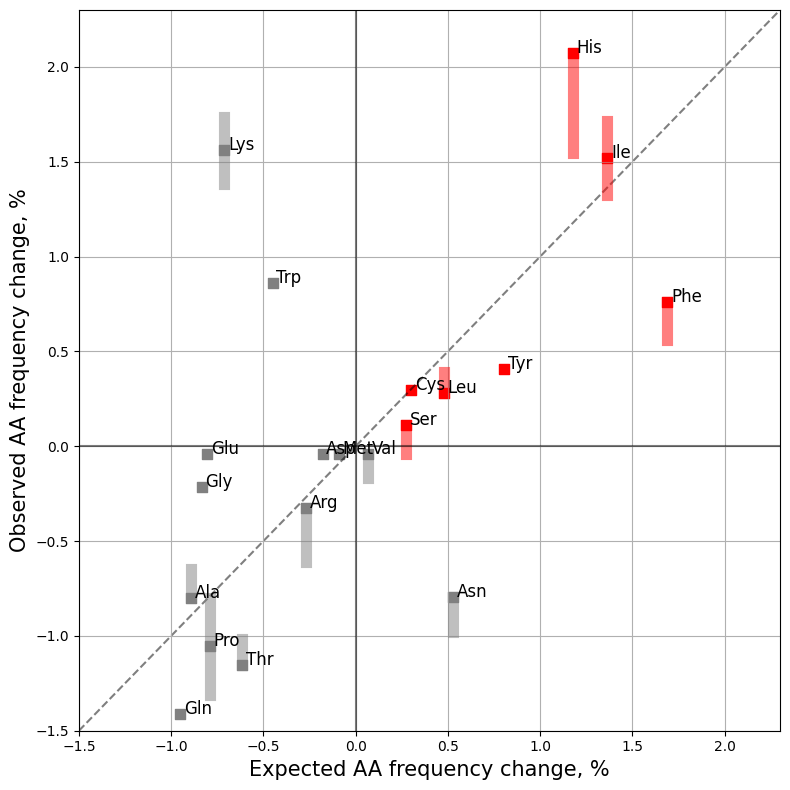

In [268]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for aa, gr in quantiles.groupby('aa'):
    eq1, eq2, eq3 = gr['PE_exp'].values
    oq1, oq2, oq3 = gr['PE_obs'].values

    if aa in losers:
        color = 'blue'
    elif aa in gainers:
        color = 'red'
    else:
        color = 'gray'
    plt.plot(gr['PE_exp'], gr['PE_obs'], '-', color=color, label=aa, alpha=0.5, linewidth=8)
    plt.scatter(eq2, oq2,  s=50, marker='s', c=color)
    plt.text(eq2+0.02, oq2, aa, fontsize=12, ha='left', va='baseline')


ax.plot([-1.5, 2.5], [-1.5, 2.5], 'k--', alpha=0.5, zorder=1)
plt.grid()
plt.xlabel('Expected AA frequency change, %', fontsize=15)
plt.ylabel('Observed AA frequency change, %', fontsize=15)
# plt.xlabel('Ожидаемое изменение частоты, %', fontsize=15)
# plt.ylabel('Наблюдаемое изменение частоты, %', fontsize=15)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, 2.3]
xbound = [-1.5, 2.3]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

<Axes: >

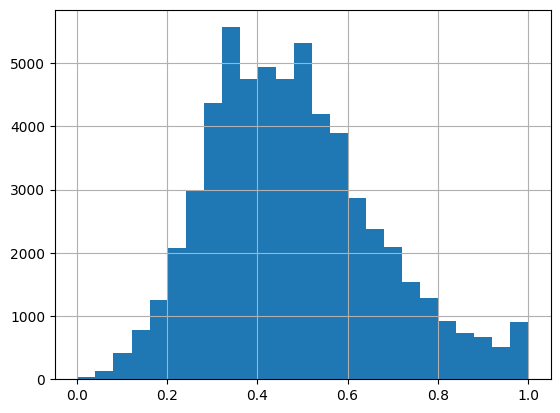

In [124]:
normality = df_change_total.groupby('Accession ID').apply(lambda x: shapiro(x['PE_obs'])[1])
normality.hist(bins=25)
plt.xlabel('shapiro p-val')

np.float64(0.5691887348986745)

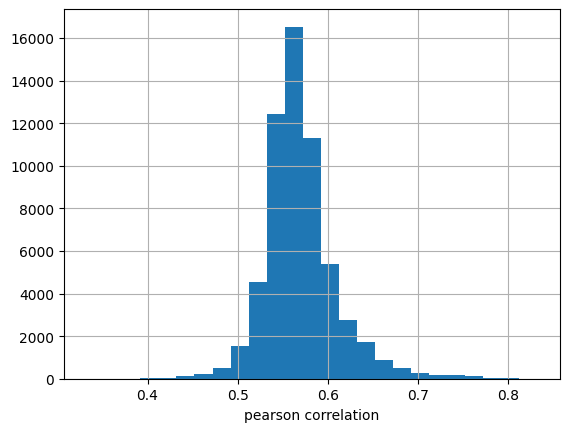

In [ ]:
correlation = df_change_total.groupby('Accession ID')\
    .apply(lambda x: pearsonr(x['PE_obs'], x['PE_exp']))

correlation.apply(lambda x: x[0]).hist(bins=25)
plt.xlabel('pearson correlation')
correlation.apply(lambda x: x[0]).mean()

np.float64(0.010238786851872192)

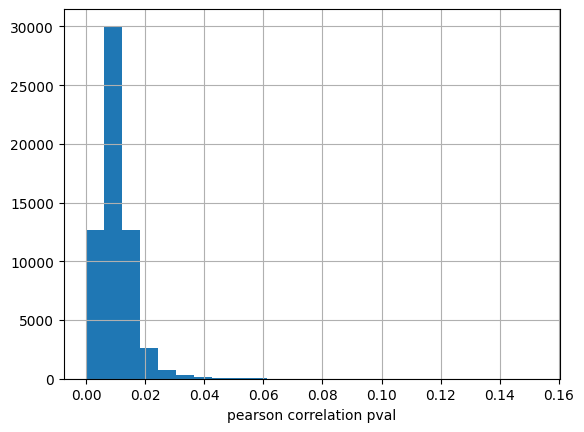

In [127]:
correlation.apply(lambda x: x[1]).hist(bins=25)
plt.xlabel('pearson correlation pval')
correlation.apply(lambda x: x[1]).mean()

## compare simulation equilibrium with true one

Just QC of method

1. eig vec of aa
2. eig vec of cdn
3. sim of aa
4. sim of cdn

In [ ]:
def main_test():
    # 1. Setup Data
    np.random.seed(42)
    n_aa = 20 # Amino acids
    Q = get_random_rate_matrix(n_aa)
    
    # Initial state: 100% start at Amino Acid 0 (e.g., Alanine)
    pi_0 = np.zeros(n_aa)
    pi_0[0] = 1.0
    
    # Increased time to ensure we reach equilibrium for visual comparison
    T_max = 20.0 
    
    # 2. Run Simulations
    
    # Run Exact Method
    t_exact, res_exact = simulate_exact_method(Q, pi_0, T_max, steps=100)
    
    # Run Euler Method (Small step)
    dt_small = 0.01
    t_euler, res_euler = simulate_euler_method(Q, pi_0, T_max, dt_small)
    
    # 3. Calculate Equilibrium using Eigenvector approach
    pi_eq = get_equilibrium_probabilities(Q)

    # 4. Visualization
    plt.figure(figsize=(12, 6))
    
    colors = ['r', 'g', 'b', 'orange', 'k']
    labels = ['AA 1', 'AA 2', 'AA 3', 'AA 4', 'AA 5']
    
    for i in range(3):
        # Plot Exact Simulation Trajectory
        plt.plot(t_exact, res_exact[:, i], color=colors[i], linewidth=2, 
                 label=f'Simulation {labels[i]}' if i==0 else None)
        
        # Plot Equilibrium Target (Eigenvector)
        plt.axhline(y=pi_eq[i], color=colors[i], linestyle='--', alpha=0.5,
                    label=f'Equilibrium {labels[i]}' if i==0 else None)

    plt.title('Convergence to Equilibrium: Simulation vs Eigenvector Analysis')
    plt.xlabel('Evolutionary Time (t)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comparison_plot.png')
    print("Simulation complete. Comparison plot generated.")

    # 5. Numerical Comparison
    pi_final_sim = res_exact[-1]
    
    print("\n--- Equilibrium Comparison ---")
    print(f"{'Amino Acid':<12} {'Simulation (t=20)':<20} {'Eigenvector':<20} {'Difference'}")
    print("-" * 65)
    for i in range(20): # Show first 5 AAs
        diff = abs(pi_final_sim[i] - pi_eq[i])
        print(f"AA {i:<9} {pi_final_sim[i]:.6f}             {pi_eq[i]:.6f}             {diff:.2e}")
        
    total_diff = np.linalg.norm(pi_final_sim - pi_eq)
    print("-" * 65)
    print(f"Total Euclidean Distance (Norm) between vectors: {total_diff:.2e}")

# main()

Simulation complete. Comparison plot generated.

--- Equilibrium Comparison ---
Amino Acid   Simulation           Eigenvector          Difference
-----------------------------------------------------------------
Ala          0.006170             0.007127             9.57e-04
Arg          0.009977             0.009142             8.34e-04
Asn          0.032000             0.017199             1.48e-02
Asp          0.009674             0.008012             1.66e-03
Cys          0.028309             0.035283             6.97e-03
Gln          0.002774             0.005073             2.30e-03
Glu          0.001823             0.002015             1.92e-04
Gly          0.004315             0.002844             1.47e-03
His          0.019080             0.020183             1.10e-03
Ile          0.114441             0.086898             2.75e-02
Leu          0.203697             0.197825             5.87e-03
Lys          0.005523             0.004677             8.46e-04
Met          0.01465

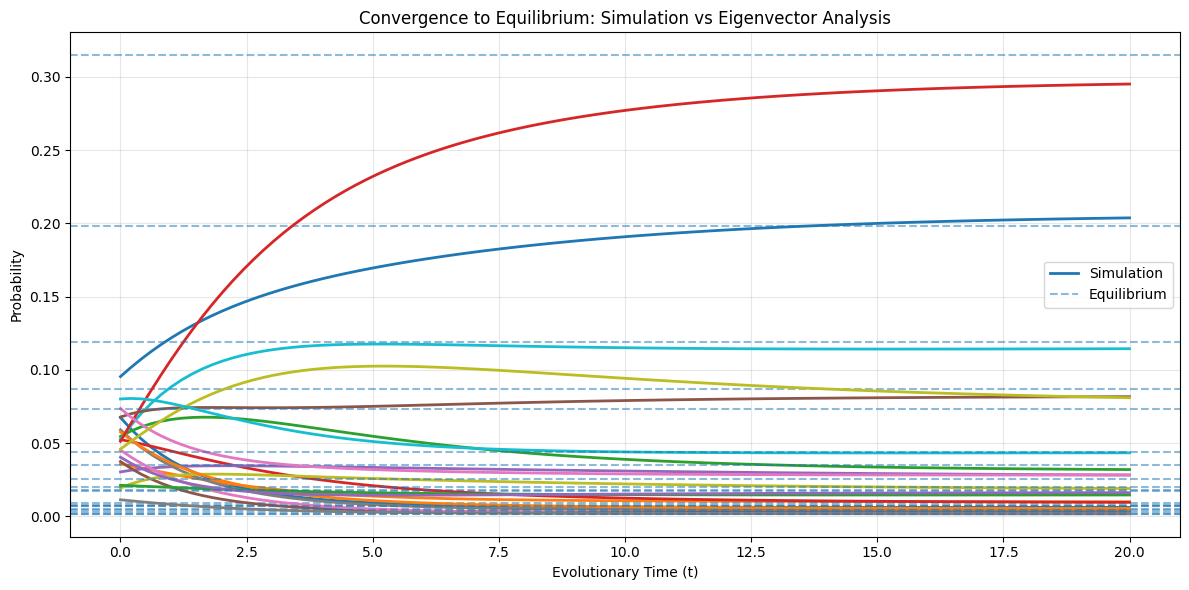

In [250]:
def main():
    # 1. Setup Data
    Q = Maa.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))
    
    # Initial state
    pi_0 = aa_init_freqs
    
    # Increased time to ensure we reach equilibrium for visual comparison
    T_max = 20.0 
    
    # 2. Run Simulations
    
    # Run Exact Method
    t_exact, res_exact = simulate_exact_method(Q, pi_0, T_max, steps=100)
    
    # 3. Calculate Equilibrium using Eigenvector approach
    pi_eq_aa_based = get_equilibrium_probabilities(Maa.values) # amino acid matrix
    
    pi_eq_cdn_based = get_equilibrium_freqs(spectrum_20A, 'rate')[1].set_index('aa')['eq_freq'] # cdn matrix
    pi_eq_cdn_based = np.array([pi_eq_cdn_based[aa] for aa in Maa.columns])
    pi_eq = pi_eq_cdn_based

    # 4. Visualization
    plt.figure(figsize=(12, 6))
        
    for i in range(20):
        # Plot Exact Simulation Trajectory
        plt.plot(t_exact, res_exact[:, i], linewidth=2, 
                 label=f'Simulation' if i==0 else None)
        
        # Plot Equilibrium Target (Eigenvector)
        plt.axhline(y=pi_eq[i], linestyle='--', alpha=0.5,
                    label=f'Equilibrium' if i==0 else None)

    plt.title('Convergence to Equilibrium: Simulation vs Eigenvector Analysis')
    plt.xlabel('Evolutionary Time (t)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comparison_plot.png')
    print("Simulation complete. Comparison plot generated.")

    # 5. Numerical Comparison
    pi_final_sim = res_exact[-1]
    
    print("\n--- Equilibrium Comparison ---")
    print(f"{'Amino Acid':<12} {'Simulation ':<20} {'Eigenvector':<20} {'Difference'}")
    print("-" * 65)
    for i in range(20): # Show first 5 AAs
        diff = abs(pi_final_sim[i] - pi_eq[i])
        print(f"{Maa.columns[i]:<12} {pi_final_sim[i]:.6f}             {pi_eq[i]:.6f}             {diff:.2e}")
        
    total_diff = np.linalg.norm(pi_final_sim - pi_eq)
    print("-" * 65)
    print(f"Total Euclidean Distance (Norm) between vectors: {total_diff:.2e}")

    print(np.linalg.norm(pi_final_sim - pi_eq_cdn_based))

main()

## Legacy

### Estimate changes TODO move some cells to the end 9legacy

In [70]:
# Assuming you have:
# transition_matrix - 64x64 numpy array
# initial_vector - 1x64 numpy array (or 64x1, will need to transpose if needed)

def simulate_markov(transition_matrix, initial_vector, num_iterations):
    current_state = initial_vector
    data = [current_state]
    for _ in range(num_iterations):
        current_state = np.dot(current_state, transition_matrix)
        data.append(current_state)
        # print(f"Current state after iteration: {current_state[:5]}")
    return data


def simulate_markov_power(transition_matrix, initial_vector, num_iterations):
    powered_matrix = np.linalg.matrix_power(transition_matrix, num_iterations)
    return np.dot(initial_vector, powered_matrix)

### test 2 approaches

In [3]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

FileNotFoundError: [Errno 2] No such file or directory: 'data/rates_by_clade.csv'

In [ ]:
from pymutspec.annotation import CodonAnnotation

# def get_equilibrium_freqs(spectrum: pd.DataFrame, rate_col='MutSpec', gc=1):
coda = CodonAnnotation(1)
df_changes = collect_possible_changes(1)
spectrum_dict = spectrum_20A.set_index('Mut')['rate'].to_dict()

df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn']\
    .map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['eq_freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()

eq_cdn1, eq_aa1 = eq_freqs_cdn, eq_freqs_aa

/tmp/ipykernel_556277/1248810473.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [ ]:
#CDN
df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)
exp_cdn_subst = cdn_sbs.reset_index()

Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
# Mcdn = Mcdn / Mcdn.sum().sum()

aa_init_freqs = np.random.rand(len(Mcdn.columns))
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()

res_cdn = simulate_markov_power(Mcdn.values, aa_init_freqs, 1000)
# pd.DataFrame({'aa': Mcdn.columns, 'eq2': res_cdn})
res_cdn

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [4]:
# eq_prob2 = get_equilibrium_probabilities(M).astype(float)
M[:5, :5]

NameError: name 'M' is not defined

In [7]:
Mcdn.sum(1).sum()

np.float64(64.0)

In [8]:
Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
# Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
Mcdn = Mcdn / Mcdn.sum().sum()
# Mcdn.values[:5, :5].T

In [9]:
Mcdn.values[:5, :5]

array([[0.        , 0.00016232, 0.00091771, 0.00029227, 0.00016232],
       [0.00040662, 0.        , 0.00015593, 0.00853154, 0.        ],
       [0.00211697, 0.0003465 , 0.        , 0.00675308, 0.        ],
       [0.00018268, 0.00084001, 0.00012772, 0.        , 0.        ],
       [0.00040662, 0.        , 0.        , 0.        , 0.        ]])

In [25]:
def cdn_spectrum_to_matrix2(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    # M /= M.sum()
    M /= M.sum(axis=0, keepdims=True)
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)
    return M

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix2(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()

/tmp/ipykernel_556277/160814893.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [26]:
M[0, 1:].sum(), M[0].sum()

(np.float64(0.7747054063269248), np.float64(-0.22529459367307506))

In [29]:
M[:5, :5]

array([[-1.        ,  0.03434637,  0.17698713,  0.04690163,  0.03434637],
       [ 0.03942677, -1.        ,  0.02896914,  0.2156633 ,  0.        ],
       [ 0.22291268,  0.01317085, -1.        ,  0.03278977,  0.        ],
       [ 0.07099388,  0.72065041,  0.56458499, -1.        ,  0.        ],
       [ 0.03942677,  0.        ,  0.        ,  0.        , -1.        ]])

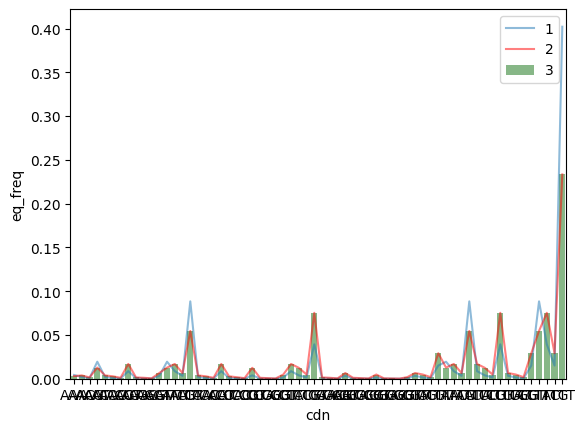

In [28]:
sns.lineplot(eq_cdn1, x='cdn', y='eq_freq', alpha=0.5, label='1')
sns.lineplot(pd.DataFrame({'cdn': Mcdn.columns, 'eq_freq': res_cdn}), 
             x='cdn', y='eq_freq', alpha=0.5, label='2', color='red')
sns.barplot(eq_freqs_cdn, x='cdn', y='eq_freq', alpha=0.5, label='3', color='g')

plt.legend()

### Main

#### Load codon counts from refseq

In [71]:
data_cdn_counts = dict()

for rec in parse('./data/refseq_data/cds.fna', 'fasta'):
    if ' ORF1ab polyprotein ' in rec.description or ' ORF1a polyprotein ' in rec.description:
        print(' pass', rec.description)
    else:
        # print(rec.description, len(rec), len(rec) % 3)
        seq = str(rec.seq)
        codons = [seq[i:i+3] for i in range(0, len(rec), 3)]
        assert seq == ''.join(codons)
        gene = ' '.join(rec.description.split()[1:]).split(' [organism=')[0]

        print(gene, codons[-1], len(codons))

        data_cdn_counts[gene] = dict(Counter(codons))

3C-like proteinase [polyprotein=ORF1ab polyprotein] CAA 306
nsp6 [polyprotein=ORF1ab polyprotein] CAG 290
nsp7 [polyprotein=ORF1ab polyprotein] CAA 83
nsp8 [polyprotein=ORF1ab polyprotein] CAG 198
nsp9 [polyprotein=ORF1ab polyprotein] CAA 113
nsp10 [polyprotein=ORF1ab polyprotein] CAG 139
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein] CAG 932
nsp11 [polyprotein=ORF1a polyprotein] GTG 13
helicase [polyprotein=ORF1ab polyprotein] CAA 601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein] CAG 527
endoRNAse [polyprotein=ORF1ab polyprotein] CAA 346
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein] AAC 298
surface glycoprotein TAA 1274
ORF3a protein TAA 276
envelope protein TAA 76
membrane glycoprotein TAA 223
 pass NC_045512.2:266-13468,13468-21555 ORF1ab polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wuhan-Hu-1]
 pass NC_045512.2:266-13483 ORF1a polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wu

In [72]:
cdn_counts_df = pd.DataFrame(data_cdn_counts).T.fillna(0).astype(int)
cdn_counts_df.to_csv('./data/refseq_data/codon_counts.csv')
cdn_counts_df.head()

,AGT,GGT,TTT,AGA,AAA,ATG,GCA,TTC,CCA,TCT,...,TCC,AGC,GCG,GGG,CCG,TCG,CGG,TAA,TGA,TAG
3C-like proteinase [polyprotein=ORF1ab polyprotein],3,17,12,3,3,10,3,5,5,7,...,0,0,0,0,0,0,0,0,0,0
nsp6 [polyprotein=ORF1ab polyprotein],4,11,17,6,8,17,5,5,1,7,...,1,1,0,0,0,0,0,0,0,0
nsp7 [polyprotein=ORF1ab polyprotein],0,1,1,1,4,4,1,0,0,3,...,1,0,0,0,0,0,0,0,0,0
nsp8 [polyprotein=ORF1ab polyprotein],5,3,4,3,8,9,10,1,2,5,...,1,0,0,0,0,0,0,0,0,0
nsp9 [polyprotein=ORF1ab polyprotein],3,6,3,2,4,2,2,1,1,1,...,1,0,1,0,0,0,0,0,0,0


In [73]:
cdn_counts_dct = cdn_counts_df.sum(0).to_dict()

In [74]:
cdn_counts_df.sum(axis=1).sort_values(ascending=False)

nsp3 [polyprotein=ORF1ab polyprotein]                             1945
surface glycoprotein                                              1274
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein]      932
nsp2 [polyprotein=ORF1ab polyprotein]                              638
helicase [polyprotein=ORF1ab polyprotein]                          601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein]              527
nsp4 [polyprotein=ORF1ab polyprotein]                              500
nucleocapsid phosphoprotein                                        420
endoRNAse [polyprotein=ORF1ab polyprotein]                         346
3C-like proteinase [polyprotein=ORF1ab polyprotein]                306
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein]     298
nsp6 [polyprotein=ORF1ab polyprotein]                              290
ORF3a protein                                                      276
membrane glycoprotein                                              223
nsp8 [

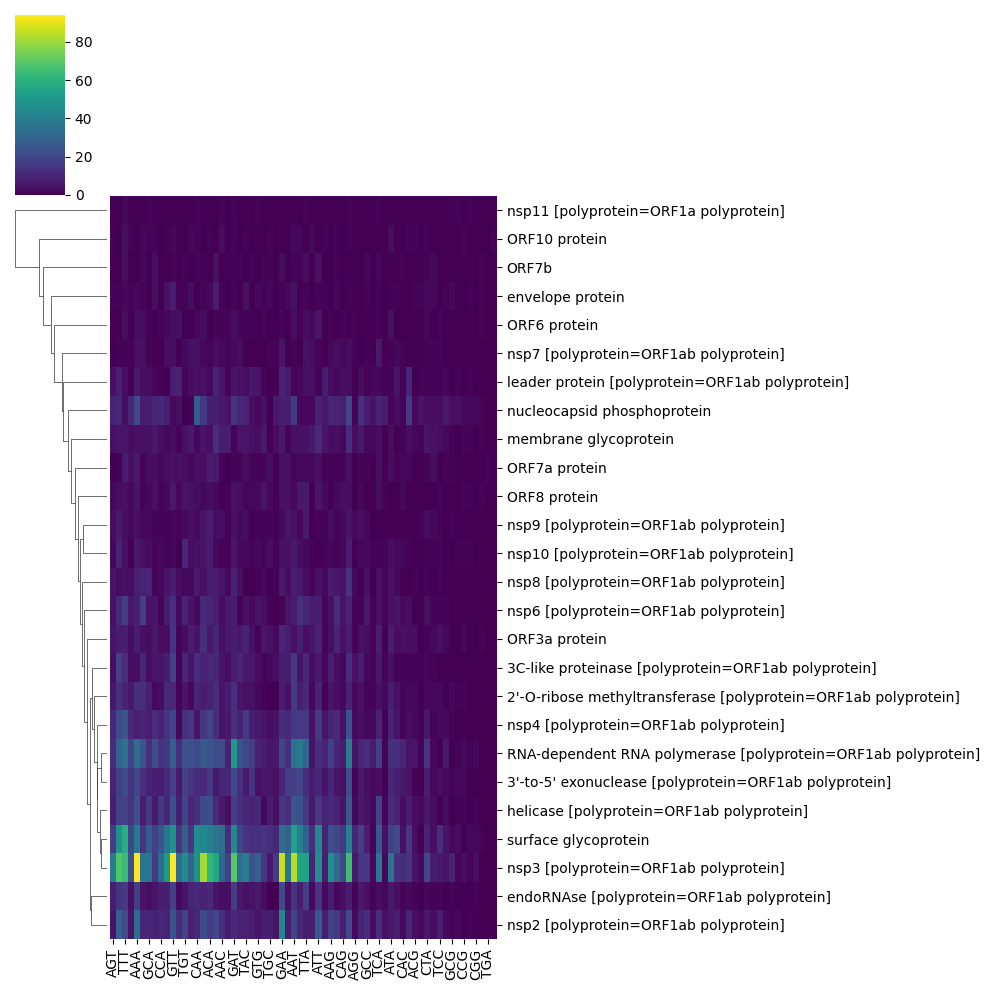

In [45]:
sns.clustermap(cdn_counts_df, cmap='viridis', figsize=(10, 10), metric='cosine',
               col_cluster=False, row_cluster=True, )

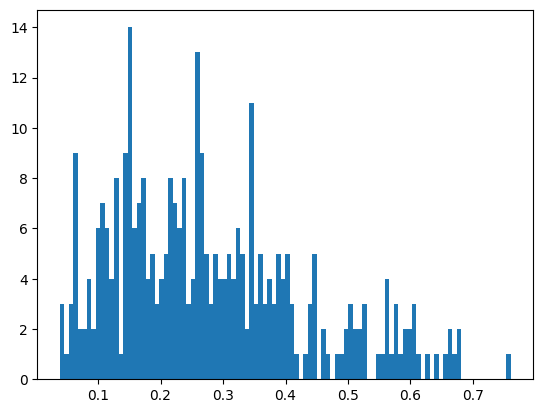

In [46]:
plt.hist(pdist(cdn_counts_df, 'cosine'), bins=100);

#### Load matrix

In [75]:
clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


In [76]:
possible_aa = list(amino_acid_codes.values())[:20]

In [77]:
eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec_cdn = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values
eq_freq_vec_aa = eq_freq_df.groupby('aa')['eq_freq'].sum().loc[possible_aa].values
eq_freq_vec_aa

array([0.00693951, 0.0089017 , 0.01674627, 0.00780098, 0.03435456,
       0.00493996, 0.00196219, 0.00276877, 0.01965224, 0.0846124 ,
       0.19262164, 0.00455425, 0.00669687, 0.30636098, 0.01739169,
       0.11614326, 0.02459221, 0.00195146, 0.07170198, 0.04300289])

#### AA

In [78]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T

In [79]:
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221693,0.000000,0.000000,0.009019,0.000000,0.000000,0.009019,0.006342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013760,0.285607,0.086291,0.000000,0.000000,0.368270
Arg,0.000000,0.214378,0.000000,0.000000,0.148752,0.034855,0.000000,0.020866,0.034855,0.057681,0.230725,0.034855,0.057681,0.000000,0.011116,0.071700,0.005558,0.076979,0.000000,0.000000
Asn,0.000000,0.000000,0.597633,0.115183,0.000000,0.000000,0.000000,0.000000,0.019758,0.038093,0.000000,0.056297,0.000000,0.000000,0.000000,0.115183,0.019758,0.000000,0.038093,0.000000
Asp,0.010047,0.000000,0.129666,0.303882,0.000000,0.000000,0.028626,0.058568,0.020676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429167,0.019369
Cys,0.000000,0.056210,0.000000,0.000000,0.314091,0.000000,0.000000,0.008976,0.000000,0.000000,0.000000,0.000000,0.000000,0.443585,0.000000,0.033705,0.000000,0.009413,0.134022,0.000000
Gln,0.000000,0.127776,0.000000,0.000000,0.000000,0.205332,0.020789,0.000000,0.522793,0.000000,0.042258,0.059133,0.000000,0.000000,0.021918,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017562,0.000000,0.000000,0.418880,0.000000,0.036142,0.164519,0.102379,0.000000,0.000000,0.000000,0.226660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033858
Gly,0.014930,0.061746,0.000000,0.046816,0.154950,0.000000,0.046816,0.240551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046816,0.000000,0.077475,0.000000,0.309901
His,0.000000,0.057959,0.026823,0.009430,0.000000,0.028328,0.000000,0.000000,0.300722,0.000000,0.019168,0.000000,0.000000,0.000000,0.009942,0.000000,0.000000,0.000000,0.547628,0.000000


In [80]:
aa_init_freqs = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_init_freqs[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [81]:
for i in range(10):
    d = euclidean(simulate_markov_power(Maa.values, aa_init_freqs, i), eq_freq_vec_aa)
    print(i, d)

res_aa = simulate_markov_power(Maa.values, aa_init_freqs, 10000)

euclidean(res_aa, eq_freq_vec_aa)

0 0.31608854463344643
1 0.23242599638175718
2 0.17588523350227162
3 0.1406227159832762
4 0.11677195009423884
5 0.09975555190004252
6 0.08722028491079847
7 0.0778466424960731
8 0.07082067026647393
9 0.06558288392847103


0.05230767846184161

In [82]:
values, vectors = np.linalg.eig(Maa.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([0.00620843, 0.00983195, 0.03107591, 0.00926792, 0.02740472,
       0.00274277, 0.00178447, 0.00426784, 0.01816612, 0.11534034,
       0.20627221, 0.00542765, 0.0147691 , 0.2976682 , 0.01646474,
       0.08219259, 0.02845308, 0.00184109, 0.0770432 , 0.04377766])

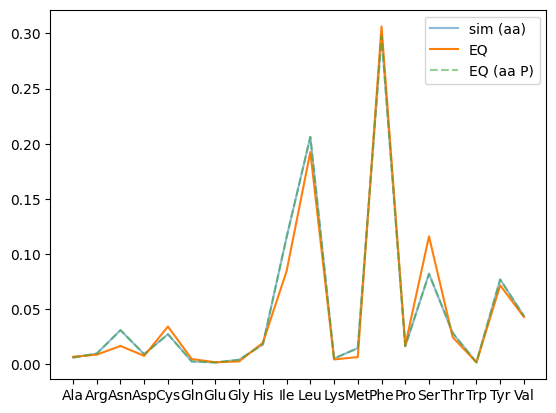

In [83]:
plt.plot(res_aa, label='sim (aa)', alpha=0.5)
plt.plot(eq_freq_vec_aa, label='EQ')
plt.plot(pi.flatten(), label='EQ (aa P)', linestyle='--', alpha=0.5)
plt.xticks(range(20), possible_aa)
plt.legend()

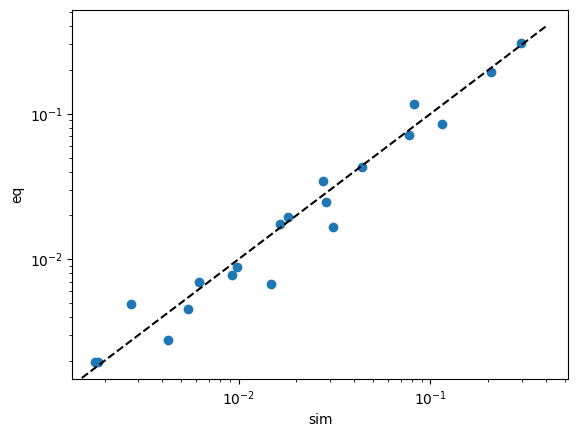

In [84]:
plt.scatter(res_aa, eq_freq_vec_aa)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [85]:
def simulate_markov_continual(transition_matrix, initial_vector, num_iterations, delta_t=0.01):
    pi = initial_vector.copy()
    data = [pi.copy()]
    Q = transition_matrix.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator
    for _ in range(num_iterations):
        pi_new = pi + delta_t * (pi @ Q)
        pi_new = pi_new / pi_new.sum()
        data.append(pi_new.copy())
        if np.linalg.norm(pi_new - pi) < 1e-8:
            break
        pi = pi_new
    return data

In [86]:
sim_data = simulate_markov_continual(Maa.values, aa_init_freqs, 10, delta_t=0.01)
sim_data_df = pd.DataFrame(sim_data, columns=Maa.columns.values)
sim_data_df.index.name = 'replica'
sim_data_df_long = sim_data_df.melt(ignore_index=False, value_name='freq', var_name='aa').reset_index()
sim_data_df_long

,replica,aa,freq
0,0,Ala,0.067529
1,1,Ala,0.067119
2,2,Ala,0.066711
3,3,Ala,0.066307
4,4,Ala,0.065905
...,...,...,...
215,6,Val,0.080346
216,7,Val,0.080371
217,8,Val,0.080395
218,9,Val,0.080417


In [87]:
ref_freq_df = pd.DataFrame(
    {'replica':0, 'freq': dict(zip(possible_aa, aa_init_freqs))})\
        .reset_index(names='aa')
ref_freq_df.head()

,aa,replica,freq
0,Ala,0,0.067529
1,Arg,0,0.035920
2,Asn,0,0.054598
3,Asp,0,0.052443
4,Cys,0,0.030378


In [88]:
aa_content25 = pd.read_csv('./data/mean_aa_content_2025.csv', header=None, index_col=0)[1]
aa_content25 /= aa_content25.sum()
df_aa_content25 = aa_content25.sort_index().reset_index()
df_aa_content25.columns = ['aa', 'freq']
df_aa_content25['replica'] = -0.5
aa_content25vec = df_aa_content25['freq'].values
df_aa_content25

,aa,freq,replica
0,Ala,0.066995,-0.5
1,Arg,0.035784,-0.5
2,Asn,0.054137,-0.5
3,Asp,0.052410,-0.5
4,Cys,0.030491,-0.5
5,Gln,0.036946,-0.5
6,Glu,0.045326,-0.5
7,Gly,0.058981,-0.5
8,His,0.019764,-0.5
9,Ile,0.053442,-0.5


In [89]:
for i, p in enumerate(simulate_markov_continual(Maa.values, aa_init_freqs, 30, delta_t=0.0005)):
    print(i, np.linalg.norm(p - aa_content25.loc[Maa.columns.values].values)*1000)

0 1.8787051130098928
1 1.8469919692301497
2 1.816746689043914
3 1.7880421995048168
4 1.7609522639747617
5 1.7355508805713311
6 1.7119115867995034
7 1.6901066743403257
8 1.6702063228239354
9 1.6522776668668366
10 1.6363838164005369
11 1.622582855941636
12 1.6109268534334034
13 1.6014609130559152
14 1.594222308397958
15 1.5892397321466794
16 1.5865326956977857
17 1.5861111067863265
18 1.5879750456428128
19 1.5921147508313611
20 1.598510815596963
21 1.6071345851411967
22 1.617948735675633
23 1.630908008170199
24 1.6459600640062186
25 1.6630464265665856
26 1.6821034721634867
27 1.7030634353714944
28 1.7258553973623558
29 1.750406230677662
30 1.7766414794527503


In [90]:
df_change = pd.DataFrame([
    aa_init_freqs,
    simulate_markov_continual(Maa.values, aa_init_freqs, 18, delta_t=0.0005)[-1],
    aa_content25.loc[Maa.columns.values],
], index=['refseq', 'sim1', 'gisaid25'], columns=Maa.columns.values
).T

# df_change['PE'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']

df_change['PE_exp'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_exp'] = df_change['PE_exp'] / df_change['PE_exp'].abs()
df_change['PE_obs'] = (df_change['gisaid25'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_obs'] = df_change['PE_obs'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PE_exp'].gt(0) == df_change['PE_obs'].gt(0)# & \
    # df_change['PE_obs'].abs().gt(0.5)
df_change['PEdelta'] = (df_change['PE_exp'] - df_change['PE_obs']).abs()
df_change['err'] = df_change['PEdelta'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PEdelta'] < 1

df_change

,refseq,sim1,gisaid25,PE_exp,PE_obs,correct_direction,PEdelta,err
Ala,0.067529,0.067161,0.066995,-0.545023,-0.789677,True,0.244654,0.309815
Arg,0.035920,0.035861,0.035784,-0.163341,-0.378507,True,0.215166,0.568461
Asn,0.054598,0.054774,0.054137,0.322995,-0.843977,False,1.166972,1.382706
Asp,0.052443,0.052385,0.052410,-0.108789,-0.062657,True,0.046133,0.736276
Cys,0.030378,0.030434,0.030491,0.184982,0.372296,True,0.187314,0.503132
Gln,0.037459,0.037241,0.036946,-0.582492,-1.368652,True,0.786160,0.574405
Glu,0.045361,0.045138,0.045326,-0.492166,-0.078299,True,0.413867,5.285710
Gly,0.059113,0.058812,0.058981,-0.509820,-0.223768,True,0.286053,1.278345
His,0.019397,0.019536,0.019764,0.720453,1.892014,False,1.171561,0.619214
Ile,0.052648,0.053087,0.053442,0.834024,1.509212,True,0.675189,0.447378


In [91]:
df_change['err'].mean()

np.float64(1.7844868283892832)

<Axes: >

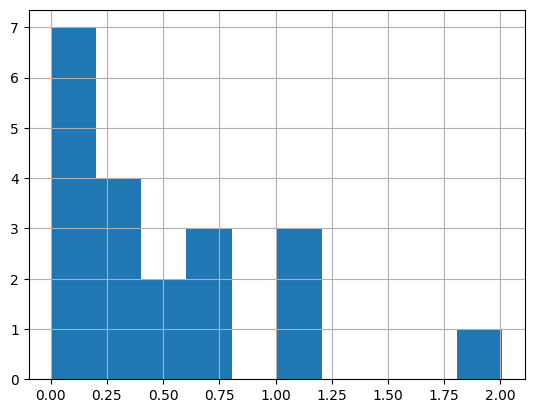

In [92]:
df_change['PEdelta'].hist()

In [93]:
from scipy.stats import pearsonr, shapiro
a = df_change['PE_exp']
b = df_change['PE_obs']
print(shapiro(a))
print(shapiro(b))
print(pearsonr(a, b))

ShapiroResult(statistic=np.float64(0.9221390925706092), pvalue=np.float64(0.1089444574592004))
ShapiroResult(statistic=np.float64(0.9579761751128437), pvalue=np.float64(0.5042545318905256))
PearsonRResult(statistic=np.float64(0.582024536437903), pvalue=np.float64(0.007095934219430102))


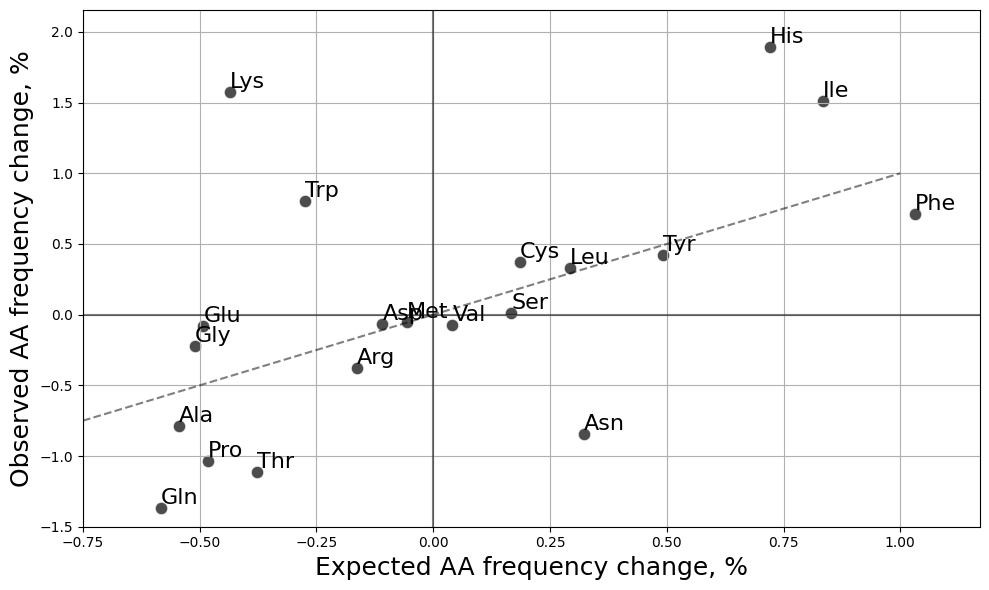

In [94]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(df_change, x='PE_exp', y='PE_obs', 
                s=80, color='black', alpha=0.7,
                # style='correct_direction', hue='correct_direction',
                # markers={True: 'o', False: 'X'}, legend=False,
                # palette={True: 'green', False: 'red'},
)
plt.plot([-0.75, 1], [-0.75, 1], 'k--', alpha=0.5)
for aa, row in df_change.iterrows():
    plt.text(row['PE_exp'], row['PE_obs'], aa, fontsize=16, ha='left', va='bottom')
plt.grid()
# plt.xlabel('Predicted amino acid frequency change, %')
# plt.ylabel('Observed amino acid frequency change, %')
plt.xlabel('Expected AA frequency change, %', fontsize=18)
plt.ylabel('Observed AA frequency change, %', fontsize=18)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, ybound[1] + 0.1]
xbound = [-0.75, xbound[1] + 0.05]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
# plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

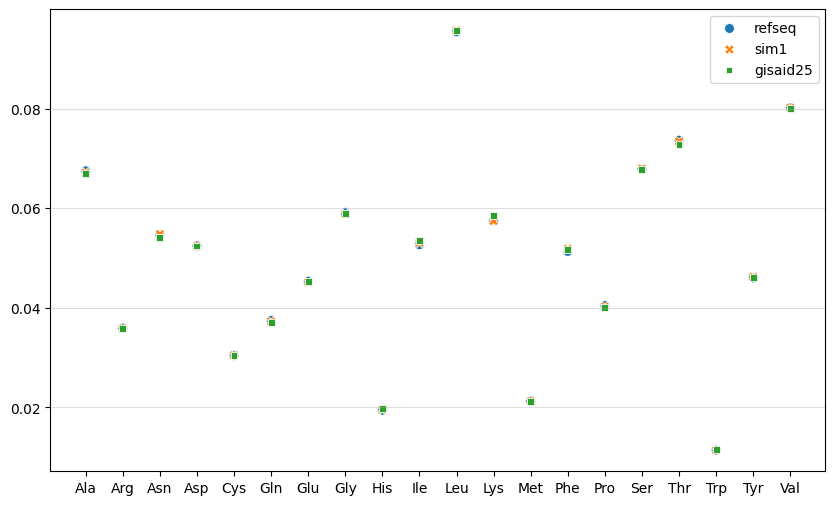

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df_change.iloc[:, :3], s=50)
plt.grid(alpha=0.4, axis='y')

In [97]:
aa_content25total = pd.read_csv('./data/aa_content_2025.csv', index_col=0)
aa_content25total_freqs = (aa_content25total.T / aa_content25total.sum(axis=1)).T
aa_content25total_freqs_wide = aa_content25total_freqs.melt(
    ignore_index=False, value_name='gisaid25', var_name='aa')
aa_content25total_freqs_wide['refseq'] = aa_content25total_freqs_wide['aa']\
    .map(df_change['refseq'].to_dict())
aa_content25total_freqs_wide['sim1'] = aa_content25total_freqs_wide['aa']\
    .map(df_change['sim1'].to_dict())
df_change_total = aa_content25total_freqs_wide.copy()


df_change_total['PE_exp'] = (df_change_total['sim1'] - df_change_total['refseq']) / df_change_total['refseq']*100
df_change_total['PE_obs'] = (df_change_total['gisaid25'] - df_change_total['refseq']) / df_change_total['refseq']*100

df_change_total

,aa,gisaid25,refseq,sim1,PE_exp,PE_obs
Accession ID,,,,,,
EPI_ISL_19674224,Pro,0.040008,0.040435,0.040240,-0.482599,-1.055846
EPI_ISL_19674372,Pro,0.040008,0.040435,0.040240,-0.482599,-1.055846
EPI_ISL_19675602,Pro,0.040008,0.040435,0.040240,-0.482599,-1.055846
EPI_ISL_19674356,Pro,0.040111,0.040435,0.040240,-0.482599,-0.802143
EPI_ISL_19674361,Pro,0.039906,0.040435,0.040240,-0.482599,-1.309549
...,...,...,...,...,...,...
EPI_ISL_19885825,Met,0.021235,0.021244,0.021232,-0.055539,-0.041034
EPI_ISL_19885820,Met,0.021133,0.021244,0.021232,-0.055539,-0.523928
EPI_ISL_19885830,Met,0.021235,0.021244,0.021232,-0.055539,-0.041034


In [98]:
1187220/20

59361.0

In [99]:
a = df_change_total.reset_index().groupby('Accession ID').apply(lambda x: pearsonr(x['PE_exp'], x['PE_obs']))
a

/tmp/ipykernel_8783/2556254893.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = df_change_total.reset_index().groupby('Accession ID').apply(lambda x: pearsonr(x['PE_exp'], x['PE_obs']))


Accession ID
EPI_ISL_19646650    (0.6377811768943024, 0.0024832430896642066)
EPI_ISL_19650969     (0.5897476517139654, 0.006203367707480135)
EPI_ISL_19650970      (0.560585167357562, 0.010138028881341922)
EPI_ISL_19650971     (0.6762292950299886, 0.001062505681549668)
EPI_ISL_19654244     (0.5328370775335952, 0.015565922714104086)
                                       ...                     
EPI_ISL_19885828     (0.6027703374316868, 0.004907950215264109)
EPI_ISL_19885829     (0.5900029793331097, 0.006175514364505194)
EPI_ISL_19885830     (0.5880491305162355, 0.006391294693623788)
EPI_ISL_19885831     (0.5444450447505095, 0.013065731670574562)
EPI_ISL_19885832     (0.5794377065880776, 0.007417402663389619)
Length: 59361, dtype: object

np.float64(0.5694989176471565)

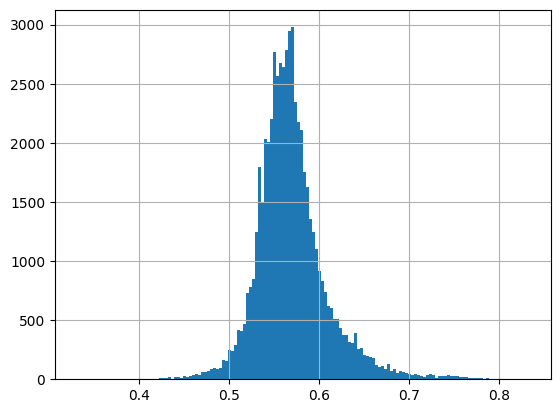

In [100]:
a.apply(lambda x: x[0]).hist(bins=150)
a.apply(lambda x: x[0]).mean()

np.float64(0.010188081120343206)

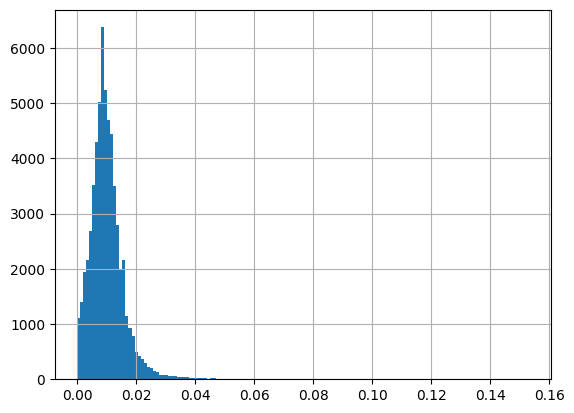

In [101]:
a.apply(lambda x: x[1]).hist(bins=150)
a.apply(lambda x: x[1]).mean()

In [102]:
quantiles = df_change_total.groupby('aa')[['PE_exp', 'PE_obs']].quantile([0.25, 0.5, 0.75])
quantiles.index.names = ['aa', 'quantile']
quantiles = quantiles.reset_index()
quantiles.head()

,aa,quantile,PE_exp,PE_obs
0,Ala,0.25,-0.545023,-0.800601
1,Ala,0.50,-0.545023,-0.800601
2,Ala,0.75,-0.545023,-0.648687
3,Arg,0.25,-0.163341,-0.612228
4,Arg,0.50,-0.163341,-0.326631


In [104]:
losers = []
gainers = ['Ser', 'Leu', 'His', 'Ile', 'Cys', 'Tyr', 'Phe']

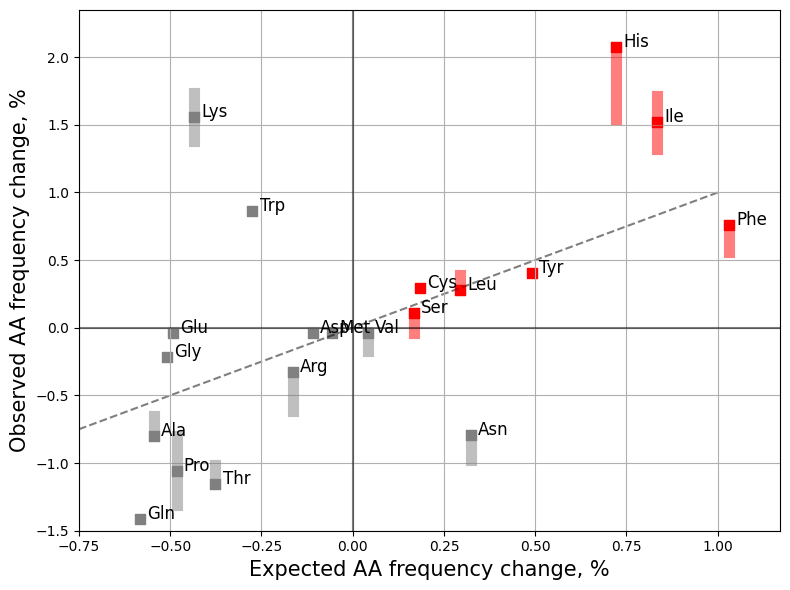

In [105]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for aa, gr in quantiles.groupby('aa'):
    eq1, eq2, eq3 = gr['PE_exp'].values
    oq1, oq2, oq3 = gr['PE_obs'].values

    if aa in losers:
        color = 'blue'
    elif aa in gainers:
        color = 'red'
    else:
        color = 'gray'
    plt.plot(gr['PE_exp'], gr['PE_obs'], '-', color=color, label=aa, alpha=0.5, linewidth=8)
    plt.scatter(eq2, oq2,  s=50, marker='s', c=color)
    plt.text(eq2+0.02, oq2, aa, fontsize=12, ha='left', va='baseline')


ax.plot([-0.75, 1], [-0.75, 1], 'k--', alpha=0.5, zorder=1)
plt.grid()
plt.xlabel('Expected AA frequency change, %', fontsize=15)
plt.ylabel('Observed AA frequency change, %', fontsize=15)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, ybound[1] + 0.1]
xbound = [-0.75, xbound[1] + 0.05]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

#### CDN

In [33]:
# TEST

transition_matrix = np.array([
    [0.25, 0.5, 0.25],
    [0, 0.5, 0.5],
    [0.33, 0.33, 0.34]
])
initial_vector = np.array([0, 0.5, 0.5])  # Starting in state 0
simulate_markov_power(transition_matrix, initial_vector, 1)

array([0.165, 0.415, 0.42 ])

In [34]:
def prepare_exp_cdn_subst(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None):
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()

    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    ## Calculate expected AA substitutions matrix
    exp_cdn_subst = df_changes[(df_changes.cdn1 != '*')&(df_changes.cdn2 != '*')]\
        .groupby(['cdn1', 'cdn2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_cdn_subst.to_csv(save_path, float_format='%g', index=False)
    exp_cdn_subst_matrix = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
    exp_cdn_subst_matrix = exp_cdn_subst_matrix.loc[possible_codons, possible_codons]
    return exp_cdn_subst, exp_cdn_subst_matrix

In [35]:
_, exp_cdn_subst_matrix = prepare_exp_cdn_subst(spectrum_20A, 'rate', 1)
exp_cdn_subst_matrix = (exp_cdn_subst_matrix.T / exp_cdn_subst_matrix.sum(1)).T
# np.fill_diagonal(exp_cdn_subst_matrix, 0)
# exp_cdn_subst_matrix /= exp_cdn_subst_matrix.sum(axis=1)

In [36]:
values, vectors = np.linalg.eig(exp_cdn_subst_matrix.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [37]:
exp_cdn_subst_matrix.sum(1)

cdn1
AAA    1.0
AAC    1.0
AAG    1.0
AAT    1.0
ACA    1.0
      ... 
TGT    1.0
TTA    1.0
TTC    1.0
TTG    1.0
TTT    1.0
Length: 64, dtype: float64

In [38]:
Q = exp_cdn_subst_matrix.values
Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator

values, vectors = np.linalg.eig(Q.T)
pi2 = vectors[:, np.isclose(values, 0)].real
pi2 = pi2 / pi2.sum()
pi2.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [47]:
transition_matrix = exp_cdn_subst_matrix.copy().values
# transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

initial_vector = np.array([cdn_counts_dct[x] for x in possible_codons])
initial_vector = initial_vector / initial_vector.sum()

eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values

# Run 10 iterations
print(euclidean(initial_vector, eq_freq_vec))
# for i in range(10):
#     result = simulate_markov_power(transition_matrix, initial_vector, i)
#     print(euclidean(result, eq_freq_vec))
result = simulate_markov_power(transition_matrix, initial_vector, 10)
# print(euclidean(result, eq_freq_vec))
# print(eq_freq_vec.sum(), initial_vector.sum(), result.sum(), result.round(3))

0.24609335865624904


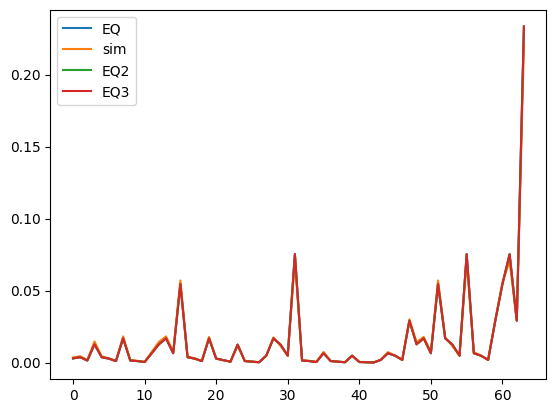

In [48]:
plt.plot(eq_freq_vec_cdn, label='EQ')
plt.plot(result, label='sim')
plt.plot(pi.flatten(), label='EQ2')
plt.plot(pi2.flatten(), label='EQ3')
plt.legend()

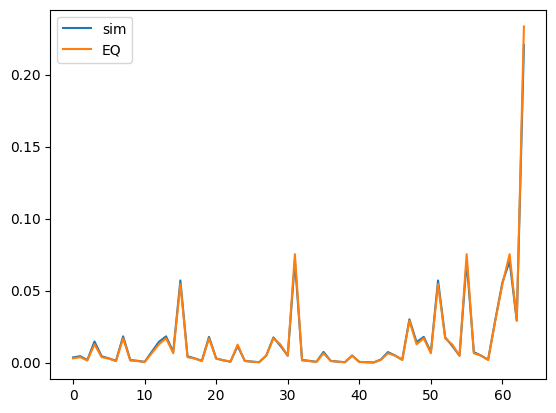

In [49]:
plt.plot(result, label='sim')
plt.plot(eq_freq_vec, label='EQ')
plt.legend()

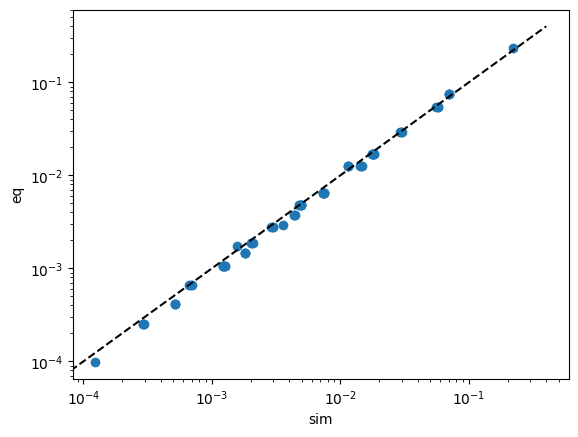

In [50]:
plt.scatter(result, eq_freq_vec)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [51]:
# Run 100 iterations
result = simulate_markov_power(transition_matrix, initial_vector, 1)
print(result)

[0.01719978 0.01315482 0.01231871 0.04009193 0.00909243 0.00471134
 0.00486378 0.01792896 0.01149017 0.00392896 0.00348922 0.01811899
 0.04379624 0.01395602 0.01019252 0.06675954 0.00484656 0.00379414
 0.00287485 0.01787515 0.00361579 0.00191485 0.00133724 0.00672789
 0.002924   0.00122457 0.00127944 0.0054583  0.01657131 0.00561309
 0.00392872 0.02922717 0.01297181 0.00575179 0.00493178 0.02819171
 0.00531696 0.00292519 0.00197365 0.01087748 0.00470893 0.00286633
 0.00182684 0.00884619 0.01992313 0.01021806 0.00528433 0.04661975
 0.04393466 0.01704679 0.01263976 0.05214291 0.020706   0.00684368
 0.00447058 0.03619023 0.0083943  0.00726464 0.00139915 0.03169412
 0.03889469 0.0238949  0.01917556 0.10176765]
